In [19]:
import pandas as pd
data = pd.read_csv("customers.csv")
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [20]:
data_cleaned=data.drop(columns=["ID","Var_1"])
data_col=list(data_cleaned.columns)
print("The shape of the data before removing null values is\nRow:"+str(data_cleaned.shape[0])+"\nColumns:"+str(data_cleaned.shape[1]))

The shape of the data before removing null values is
Row:10695
Columns:9


In [21]:
pd.DataFrame(data_cleaned.isnull().sum())

,0
Gender,0
Ever_Married,190
Age,0
Graduated,102
Profession,162
Work_Experience,1098
Spending_Score,0
Family_Size,448
Segmentation,0


In [22]:
data_cleaned=data_cleaned.dropna(axis=0)

In [23]:
pd.DataFrame(data_cleaned.isnull().sum())

,0
Gender,0
Ever_Married,0
Age,0
Graduated,0
Profession,0
Work_Experience,0
Spending_Score,0
Family_Size,0
Segmentation,0


In [24]:
print("The shape of the data after removing null values is\nRow:"+str(data_cleaned.shape[0])+"\nColumns:"+str(data_cleaned.shape[1]))

The shape of the data after removing null values is
Row:8896
Columns:9


# **Encoding the inputs using Ordinal encoder**

In [25]:
data_col_obj=list()
for c in data_col:
  if data_cleaned[c].dtype=='O':
      data_col_obj.append(c)
data_col_obj.remove("Segmentation")
print("The Columns/Features that have Objects(dataType) before encoding are:\n")
print(data_col_obj)

The Columns/Features that have Objects(dataType) before encoding are:

['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score']


In [26]:
from sklearn.preprocessing import OrdinalEncoder
data_cleaned[data_col_obj]=OrdinalEncoder().fit_transform(data_cleaned[data_col_obj])
from sklearn.preprocessing import MinMaxScaler
data_cleaned[["Age"]]=MinMaxScaler().fit_transform(data_cleaned[["Age"]])
data_cleaned.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Segmentation
0,1.0,0.0,0.056338,0.0,5.0,1.0,2.0,4.0,D
2,0.0,1.0,0.690141,1.0,2.0,1.0,2.0,1.0,B
3,1.0,1.0,0.690141,1.0,7.0,0.0,1.0,2.0,B
5,1.0,1.0,0.535211,0.0,0.0,0.0,0.0,2.0,C
6,1.0,0.0,0.197183,1.0,5.0,1.0,2.0,3.0,C


In [27]:
from sklearn.preprocessing import OneHotEncoder
y=data_cleaned[["Segmentation"]].values
y=OneHotEncoder().fit_transform(y).toarray()
pd.DataFrame(y)

,0,1,2,3
0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
8891,0.0,0.0,0.0,1.0
8892,0.0,1.0,0.0,0.0
8893,1.0,0.0,0.0,0.0
8894,0.0,0.0,1.0,0.0


In [28]:
X=data_cleaned.iloc[:,:-1]
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

# **Building the model**

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model=Sequential([
    Dense(64,input_shape=X_train.iloc[0].shape,activation="relu"),
    Dense(32,activation='tanh'),
    Dense(16,activation='relu'),
    Dense(8,activation='tanh'),
    Dense(4,activation='softmax'),
])

In [30]:
model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=15)
model.fit(x=X_train,y=y_train,
          epochs=400,
          validation_data=(X_test,y_test),
          verbose=0, 
          callbacks=[early_stop]
          )

In [31]:
metrics = pd.DataFrame(model.history.history)
metrics.iloc[metrics.shape[0]-1,:]

loss            1.149663
accuracy        0.502329
val_loss        1.185457
val_accuracy    0.479580
Name: 39, dtype: float64

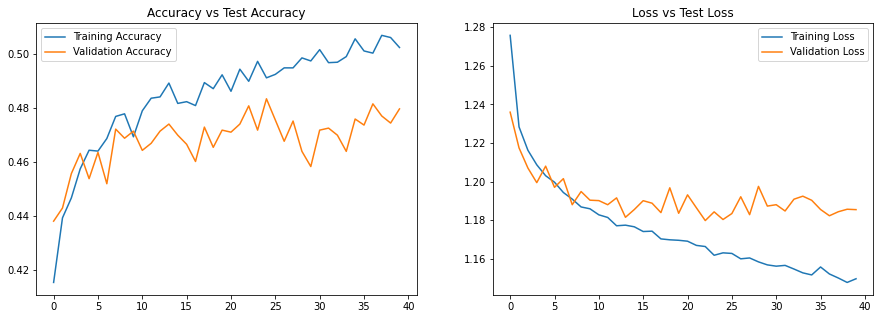

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(metrics[['accuracy','val_accuracy']])
plt.legend(["Training Accuracy","Validation Accuracy"])
plt.title("Accuracy vs Test Accuracy")
plt.subplot(1,2,2)
plt.plot(metrics[['loss','val_loss']])
plt.legend(["Training Loss","Validation Loss"])
plt.title("Loss vs Test Loss")
plt.show()

In [33]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
predictions=np.argmax(model.predict(X_test),axis=1)

In [34]:
y_test=np.argmax(y_test, axis=1)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.42      0.30      0.35       689
           1       0.38      0.25      0.30       627
           2       0.50      0.62      0.55       644
           3       0.54      0.73      0.62       709

    accuracy                           0.48      2669
   macro avg       0.46      0.47      0.46      2669
weighted avg       0.46      0.48      0.46      2669



[[208 134 125 222]
 [131 155 219 122]
 [ 62  80 398 104]
 [ 96  42  52 519]]


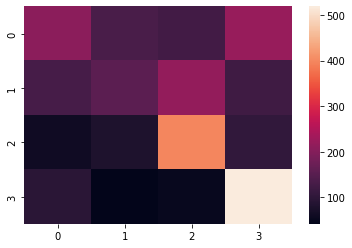

In [37]:
import seaborn as sn
print(confusion_matrix(y_test,predictions))
sn.heatmap(confusion_matrix(y_test,predictions))
plt.show()

In [68]:
Predict=np.argmax(model.predict((X_test.iloc[1:2,:])))
display(X_test.iloc[1:2,:])
print("\nFor the above data the model has predicted "+str(Predict)+"\nThe actual output is "+str(y_test[1]))

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
7282,0.0,1.0,0.28169,1.0,0.0,0.0,2.0,1.0



For the above data the model has predicted 2
The actual output is 1
